In [6]:
!unzip -q "E-Waste classification dataset.zip"

In [1]:
# Install TensorFlow package
!pip install tensorflow

In [2]:
# 📦 Import Required Libraries
import tensorflow as tf  # TensorFlow core

# Keras Modules for Model Building
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Other Core Libraries
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # For plotting graphs & images
import seaborn as sns  # For advanced data visualization
from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics
import gradio as gr  # To build simple web interface for model
from PIL import Image  # For image operations (resize, load, etc.)


In [7]:
# 📂 Dataset Directory Paths
import os  # For handling file paths

base_dir = r'/content/modified-dataset'  # Base directory (change here if needed)
trainpath = os.path.join(base_dir, 'train')  # Training dataset path
validpath = os.path.join(base_dir, 'val')    # Validation dataset path
testpath = os.path.join(base_dir, 'test')    # Test dataset path

# ✅ Now you only need to change 'base_dir' if your folder moves!


In [8]:
# 📥 Load Image Datasets from Folders
# Set common parameters
image_size = (128, 128)  # Resize all images to this size
batch_size = 32  # Number of images per batch

# Load datasets
datatrain = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

datavalid = tf.keras.utils.image_dataset_from_directory(
    validpath,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

datatest = tf.keras.utils.image_dataset_from_directory(
    testpath,
    shuffle=False,
    image_size=image_size,
    batch_size=batch_size
)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [9]:
# 📋 Display Class Names (Categories of E-Waste)
print("Number of classes:", len(datatrain.class_names))
class_names = datatrain.class_names  # Save class names for later use
print("Class Names:", class_names)

Number of classes: 10
Class Names: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


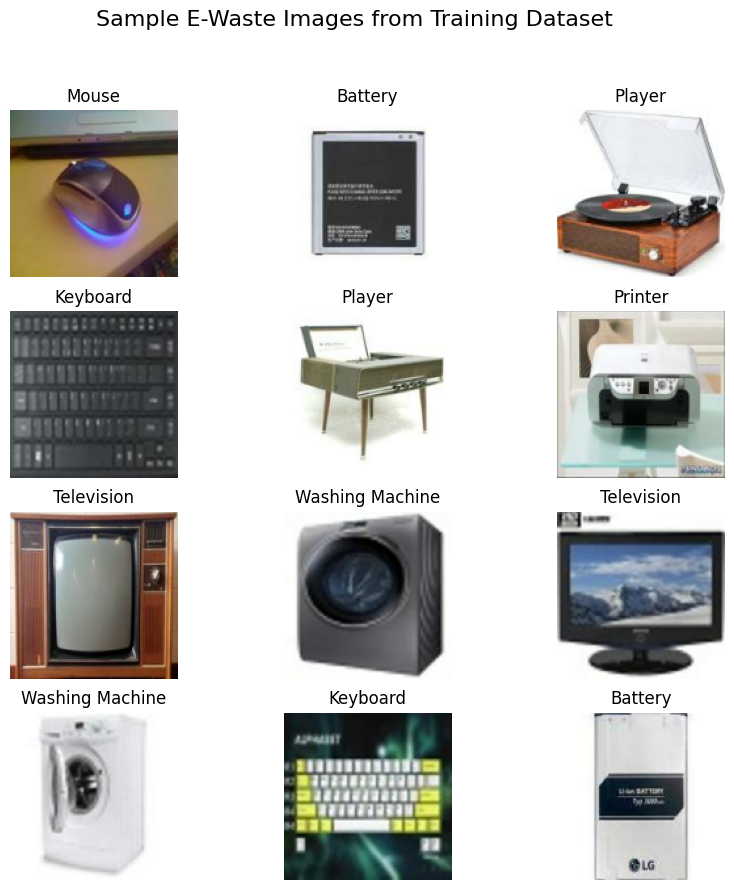

In [10]:
# 📸 Visualize Sample Images from Training Dataset
plt.figure(figsize=(10, 10))
plt.suptitle("Sample E-Waste Images from Training Dataset", fontsize=16)  # Title for entire plot

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    for i in range(12):  # Display first 12 images
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")  # Remove axis ticks for clarity

plt.show()  # Show the entire plot


In [11]:
# 📊 Function to Plot Class Distribution (Better Visualization with Seaborn)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of images per class in the given dataset.
    """
    class_counts = {}

    # Count images per class
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare data for plotting
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    # Better-looking plot using Seaborn
    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_names, y=counts, palette='pastel')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()


🔎 Visualizing Class Distributions...


/tmp/ipython-input-11-1649644017.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette='pastel')


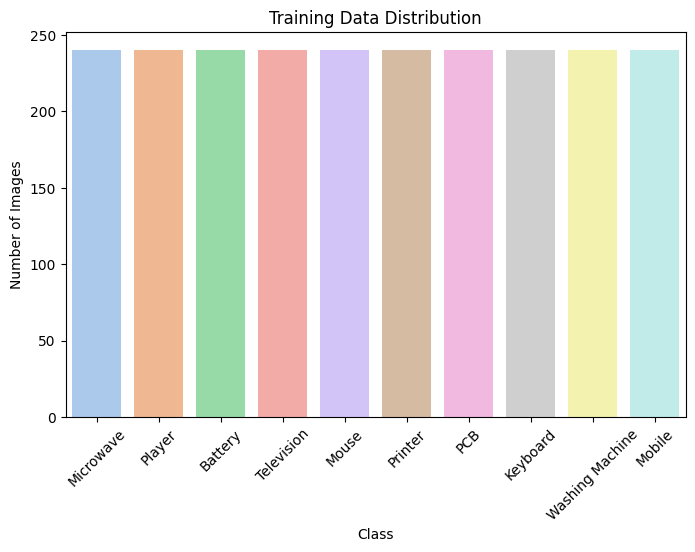

/tmp/ipython-input-11-1649644017.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette='pastel')


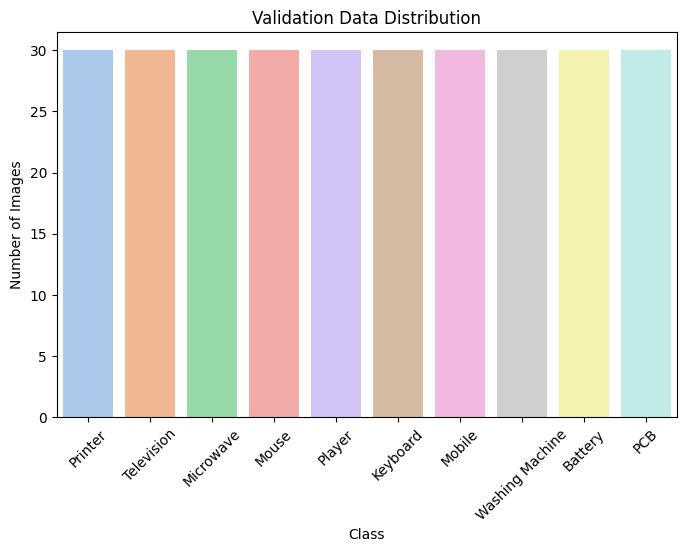

/tmp/ipython-input-11-1649644017.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette='pastel')


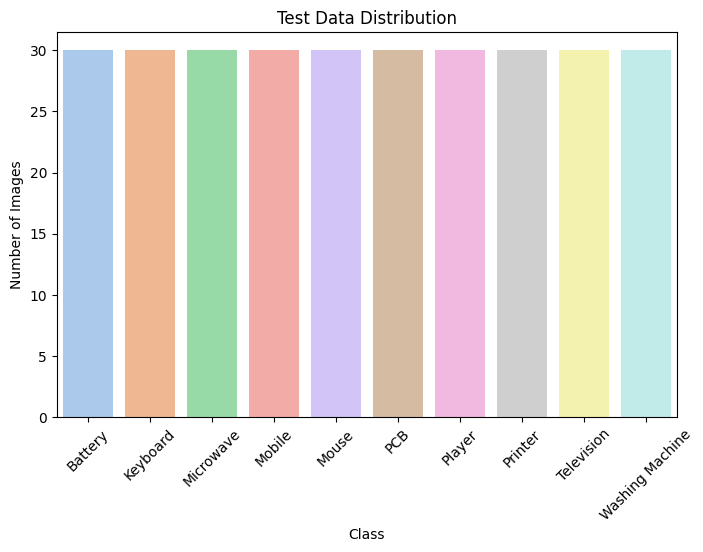

In [12]:
# 📊 Plot Class Distributions for All Datasets
print("🔎 Visualizing Class Distributions...")

plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")


In [13]:
# 🎨 Data Augmentation Layer (Improved with More Techniques)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),  # NEW: Randomly adjust contrast
    tf.keras.layers.RandomBrightness(0.2)  # NEW: Randomly adjust brightness
])


In [14]:
# ⚙️ Load Pre-trained EfficientNetV2B0 Model with Fine-tuning
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the first 100 layers for faster training & prevent overfitting
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# ✅ Print Summary of Frozen & Trainable Layers (Improvisation)
total_layers = len(base_model.layers)
frozen_layers = sum([not layer.trainable for layer in base_model.layers])
trainable_layers = total_layers - frozen_layers

print(f"Total layers in base model: {total_layers}")
print(f"Frozen layers: {frozen_layers}")
print(f"Trainable layers: {trainable_layers}")


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers in base model: 270
Frozen layers: 100
Trainable layers: 170


In [15]:
# 🏗️ Build Final Model (with Improved Learning Strategy)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['Accuracy']
)

# ✅ Easy Improvisation: Learning Rate Scheduler Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [17]:
# ⏹️ Early Stopping Callback to Prevent Overfitting
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ✅ Combine Callbacks (Easy Improvisation - Clean & Professional)
callbacks_list = [early, reduce_lr]


In [18]:
# 🚀 Train the Model (With Callbacks & Clean Code)
epochs = 10  # Number of epochs

history = model.fit(
    datatrain,                      # Training dataset
    validation_data=datavalid,      # Validation dataset
    epochs=epochs,                  # Number of epochs
    callbacks=callbacks_list        # Our organized callbacks (EarlyStopping + ReduceLROnPlateau)
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - Accuracy: 0.2496 - loss: 2.1211 - val_Accuracy: 0.7867 - val_loss: 1.1557 - learning_rate: 1.0000e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - Accuracy: 0.7469 - loss: 1.0591 - val_Accuracy: 0.8933 - val_loss: 0.5232 - learning_rate: 1.0000e-04
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - Accuracy: 0.8536 - loss: 0.5821 - val_Accuracy: 0.9433 - val_loss: 0.2981 - learning_rate: 1.0000e-04
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - Accuracy: 0.8890 - loss: 0.3876 - val_Accuracy: 0.9500 - val_loss: 0.2148 - learning_rate: 1.0000e-04
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - Accuracy: 0.9242 - loss: 0.2761 - val_Accuracy: 0.9533 - val_loss: 0.1874 - learning_rate: 1.0000e-04
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - Accuracy: 0.9304 - loss: 0.2352 - val_Accuracy: 0.9467 - val_loss: 0.1917 - learning_rate: 1.0000e-04
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - Accuracy: 0.9468 

In [19]:
# 🏗️ Model Architecture Summary
model.summary()  # Prints architecture to output

# ✅ Easy Improvisation: Save Model Summary to Text File
with open("model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

print("✅ Model summary saved as 'model_summary.txt'")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

✅ Model summary saved as 'model_summary.txt'


In [20]:
# 🏗️ Base Model (EfficientNet) Summary
base_model.summary()

# ✅ Easy Improvisation: Save Base Model Summary to Text File
with open("base_model_summary.txt", "w") as f:
    base_model.summary(print_fn=lambda x: f.write(x + '\n'))

print("✅ Base model summary saved as 'base_model_summary.txt'")


Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

✅ Base model summary saved as 'base_model_summary.txt'


In [22]:
# ✅ Extract Metrics from Training History
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


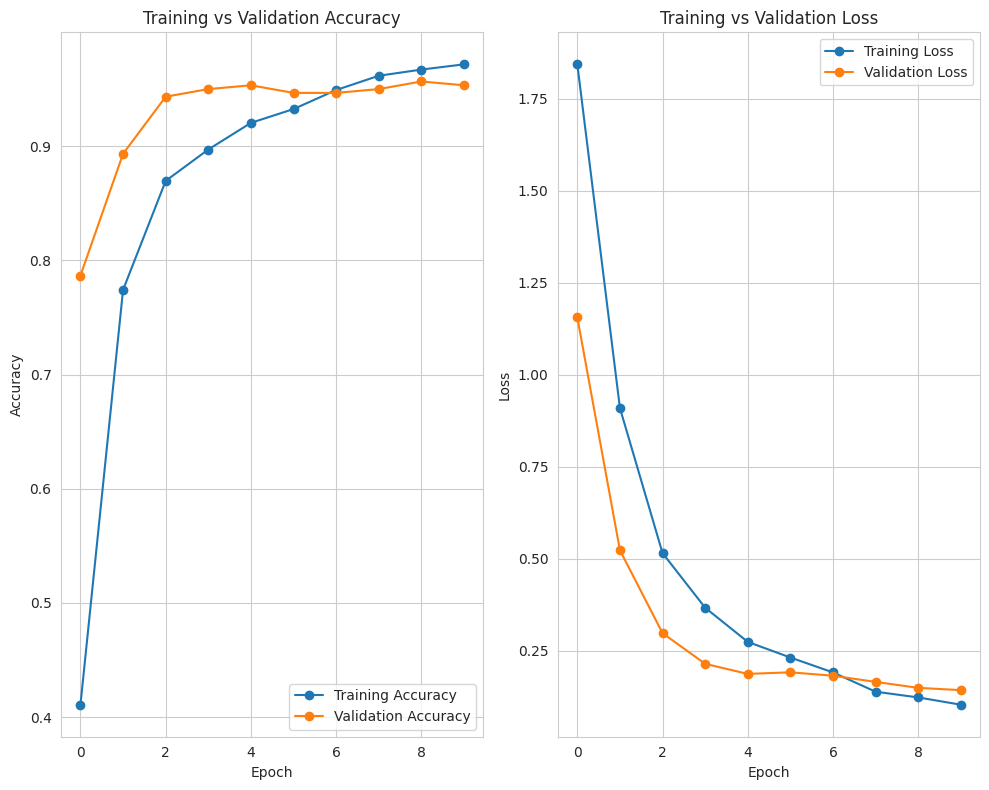

In [23]:
# 📈 Training & Validation Metrics Visualization (Improved)
import seaborn as sns
sns.set_style("whitegrid")  # ✅ Easy Improvisation: Better plot style

epochs_range = range(len(acc))  # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()  # Prevents overlapping of plots
plt.show()


In [24]:
# ✅ Evaluate Model on Test Dataset (Improved Output)
print("🔍 Evaluating Model on Test Dataset...")

loss, accuracy = model.evaluate(datatest, verbose=1)

print("\n✅ Test Evaluation Results:")
print(f"Test Accuracy : {accuracy:.4f}")
print(f"Test Loss     : {loss:.4f}")


🔍 Evaluating Model on Test Dataset...
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - Accuracy: 0.9232 - loss: 0.1895

✅ Test Evaluation Results:
Test Accuracy : 0.9367
Test Loss     : 0.1624


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 766ms/step
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       1.00      0.93      0.97        30
           2       0.88      0.93      0.90        30
           3       1.00      0.97      0.98        30
           4       1.00      0.97      0.98        30
           5       0.88      0.93      0.90        30
           6       0.85      0.93      0.89        30
           7       0.94      0.97      0.95        30
           8       1.00      0.87      0.93        30
           9       0.97      1.00      0.98        30

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



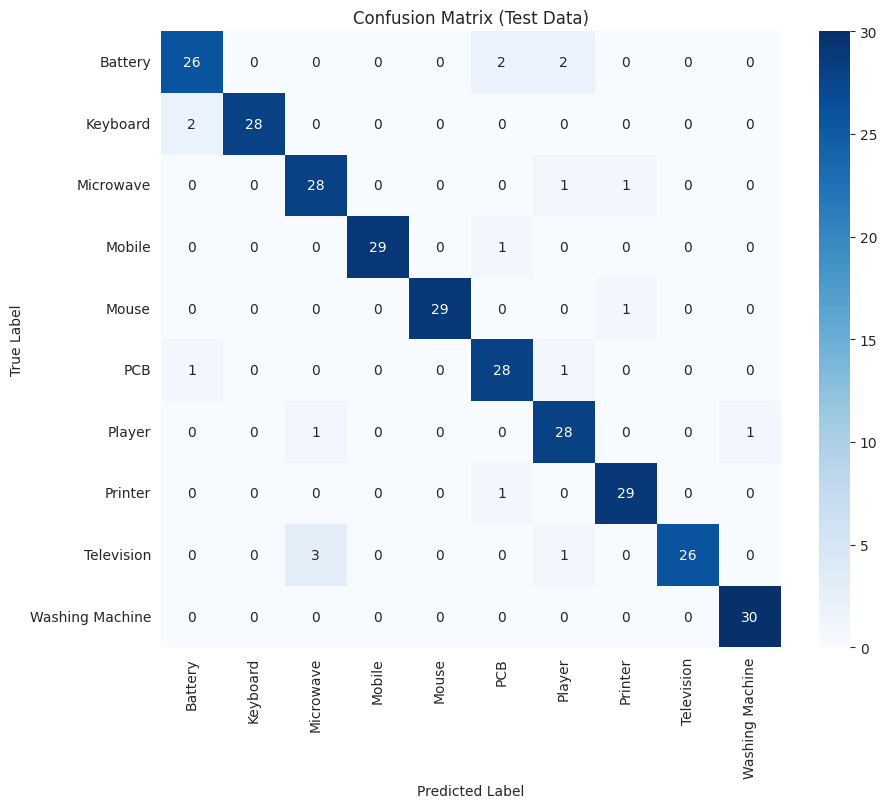

In [25]:
### 🧪 Evaluate Model Performance on Test Data (With Confusion Matrix & Report)

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)
y_pred = np.argmax(y_pred_probs, axis=1)  # Class with highest probability

# ✅ Print Classification Report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred))

# ✅ Confusion Matrix Visualization (Improvisation)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=datatest.class_names,
            yticklabels=datatest.class_names)
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


🔍 Displaying Sample Predictions from Test Set...

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


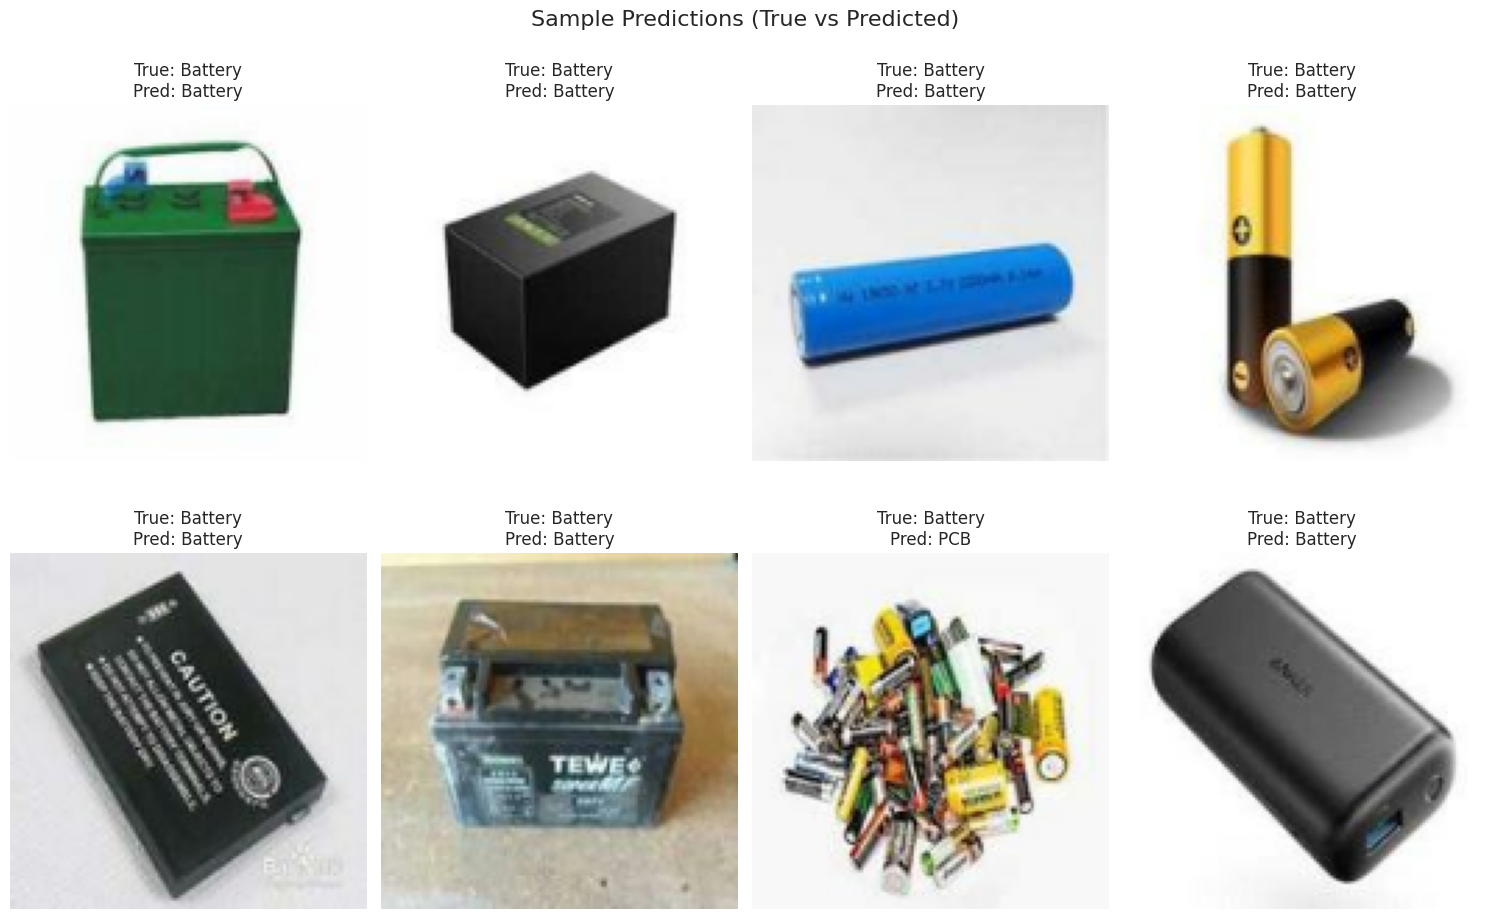

In [26]:
### 🎨 Display Sample Predictions: True Labels vs Predicted Labels (Improved)

print("🔍 Displaying Sample Predictions from Test Set...\n")

class_names = datatest.class_names

for images, labels in datatest.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.suptitle("Sample Predictions (True vs Predicted)", fontsize=16)
    plt.tight_layout()
    plt.show()


In [27]:
# 💾 Save the Trained Model (Improved with Error Handling)
try:
    model.save('Efficient_classify.keras')
    print("✅ Model saved successfully as 'Efficient_classify.keras'")
except Exception as e:
    print("❌ Error saving the model:", e)


✅ Model saved successfully as 'Efficient_classify.keras'


In [37]:
# ✅ Load Class Labels & Model (With Neat Output)
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

try:
    model = tf.keras.models.load_model('Efficient_classify.keras')
    print("✅ Model loaded successfully!")
    print("📋 Class Labels:", class_names)
except Exception as e:
    print("❌ Failed to load the model:", e)


✅ Model loaded successfully!
📋 Class Labels: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [38]:
!pip install gradio

In [39]:
def classify_image(img):
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence = prediction[0][index] * 100  # Convert to percentage

    return f"✅ Predicted Class: {class_name}\n🔍 Confidence: {confidence:.2f}%"


In [40]:
# ✅ Create a Gradio Web Interface for the Model (Improved)
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="♻️ E-Waste Classification Model",
    description="Upload an image of an electronic item to classify it into 10 e-waste categories.",
    theme="default",
    live=True  # Automatically updates on new image
)

In [41]:
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d3a24b872442d38849.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
